In [1]:
#!pip install plotly

In [2]:
# Standard Imports
import nltk
import pandas                        as pd
import numpy                         as np
import seaborn                       as sns
import matplotlib.pyplot             as plt
import re
import ftfy
from IPython.display                 import display_html
from IPython.core.display            import display, HTML

# Proprocessing, Modeling, & Evaluation
from nltk.corpus                     import stopwords
from nltk.stem                       import WordNetLemmatizer
from nltk.tokenize                   import RegexpTokenizer 
from sklearn.ensemble                import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection         import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics                 import accuracy_score, recall_score, roc_auc_score, matthews_corrcoef,roc_curve,precision_score,auc,make_scorer,precision_recall_curve
from sklearn.pipeline                import Pipeline
from sklearn.svm                     import SVC
#from sklearn.tree                    import DecisionTreeClassifier
from sklearn                         import model_selection
#from xgboost                         import XGBClassifier
from sklearn.feature_selection       import chi2,SelectKBest
   

# Custom Modules
import graphs
import metrics


# Notebook settings & styles
sns.set(style = "white", palette = "deep")
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline

In [3]:
Annotated_Sample = pd.read_csv('./Reddit Data/Reddit Eczema_All_20201201_Sample_Shuffled_Phil.csv')


In [4]:
# Downloading the default stopwords

##nltk.download("stopwords");

# Adding our stopwords to the English set

##new_stopwords = ["like", "just", "make", "cook","use", "chicken", "recipe", "sauce"]

stop_words     = stopwords.words('english')

##stopwords.extend(new_stopwords)

# Instantiating the lemmatizier and tokenizer
# The tokenizer will only keep text
## nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
tokenizer  = RegexpTokenizer(r'\w+')

In [5]:
def cleaning_data(dataframe):
   
    if 'Annotation' in dataframe :
        dataframe["label"] = dataframe["Annotation"].apply(lambda x: 1 if x == "i" else 0)
    
    #Annotated_Sample.drop(columns=['Annotation'],inplace=True)
    dataframe.rename(columns={'Author':'author'},inplace=True)
    
    #lower case
    
    #dataframe["body"] = dataframe["body"].astype(str)
    
    dataframe["body"] = dataframe["body"].str.lower()
    
    dataframe ["body"] = dataframe ["body"].map(ftfy.fix_encoding)
    
    #remove URL
    dataframe["body"] = dataframe["body"].str.replace("http\S+", "")
    
    # Setting up the lemmatizer

    lemmatized_posts = []

    for post in dataframe["body"]:
        tokens = tokenizer.tokenize(post)
        post   = [lemmatizer.lemmatize(post) for post in tokens]
        lemmatized_posts.append(" ".join(post))

    
    #remove none letters
    
    #dataframe["body"] =  dataframe["body"].apply(lambda x: re.sub(r'[^a-z]',' ',str(x)))
    

    # Appending the lemmatized posts to the dataframe

    dataframe["lemmatized_text"] = lemmatized_posts

    # Checking the head of the dataframe
    #dataframe.head()

    return dataframe


In [6]:
Annotated_Sample = cleaning_data(Annotated_Sample)
#HTML(Annotated_Sample.to_html())

### CountVectorizer

Convert a collection of text documents to a matrix of token counts

<https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html>

In [7]:
# vec_lem = CountVectorizer(ngram_range =(1,2),stop_words = stop_words,min_df=2,max_features=None, binary=True)

# vec_sample_lem     = vec_lem.fit_transform(Annotated_Sample["lemmatized_text"])

# sample_vectorized_lem     = pd.DataFrame(vec_sample_lem.toarray(), columns = vec_lem.get_feature_names())

# sum=sample_vectorized_lem.sum().sort_values(ascending=False)
# sum.head()

In [8]:
#HTML(sample_vectorized_lem.to_html())

In [9]:
# X = sample_vectorized_lem.drop("label",axis=1)
# y = Annotated_Sample["label"]
# chi_scores = chi2(X, y)

# s = pd.Series(chi_scores[0],index = X.columns)
# p = pd.Series(chi_scores[1],index = X.columns)
# chi= pd.concat([s, p,sum], axis=1)

# chi.sort_values(by=0,ascending = False , inplace = True)
# #chi.head(100)

In [10]:
# #sample_vectorized_lem ["label"] = Annotated_Sample["label"]
# #sample_vectorized_lem[sample_vectorized_lem.columns[1:]].corr()['label'][:]
# X_new = SelectKBest(chi2, k=50).fit_transform(X, y)

# print(X_new.shape)

### TfidfVectorizer

TF-IDF (term frequency-inverse document frequency) was invented for document search and information retrieval. It works by increasing proportionally to the number of times a word appears in a document, but is offset by the number of documents that contain the word. 


<https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html>

In [11]:
# tvec_lem = TfidfVectorizer(ngram_range =(1,2),stop_words = stop_words,max_features=None)

# tvec_sample_lem     = tvec_lem.fit_transform(Annotated_Sample["lemmatized_text"])

# tsample_vectorized_lem     = pd.DataFrame(tvec_sample_lem.toarray(),columns = tvec_lem.get_feature_names())

# tsample_vectorized_lem.T[0].sort_values(ascending=False)

In [12]:
# X = tsample_vectorized_lem.drop("label",axis=1)
# y = Annotated_Sample["label"]
# chi_scores = chi2(X, y)

# s = pd.Series(chi_scores[0],index = X.columns)
# p = pd.Series(chi_scores[1],index = X.columns)
# chi= pd.concat([s, p,sum], axis=1)

# chi.sort_values(by=0,ascending = False , inplace = True)
# #chi.head(50)

# Modelling

__Create Test and Training data split__

In [13]:
X = Annotated_Sample["lemmatized_text"]
y = Annotated_Sample["label"]

# The random state ensures reproducability
# The stratify argument preserves the distribution of classes

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state = 42,
                                                    stratify     = y)

## Support Vector Classifier

A support vector machine (in this case a classifier) is at its core a linear model. However, instead of running like a logistic regression, it seeks to linearly separate the data. To do that, it uses a kernel to raise the data into n-dimensional space. It then uses a line, plane (3-dimensional line), or hyperplane (greater than 3-dimensions) to delineate the data



### Count Vector

In [14]:
# Setting up the count vector pipeline

cvec_svc_pipe = Pipeline([("cvec", CountVectorizer()),
                          ("bestf",SelectKBest()),
                          ("svc", SVC())])

#### Count Vector + SVM Kernel - Linear 


In [15]:
# Setting CVEC and pipe hyperparameters
cvec_linear_pipe_params = {"cvec__max_features": [None], 
                    "cvec__ngram_range" : [(1,2)], 
                    "cvec__stop_words"  : [stop_words],
                    "cvec__binary"      : [True,False],
                    "cvec__min_df"      : [2],
                    "bestf__score_func" : [chi2],
                    "bestf__k"          : [250,300,350],       
                    "svc__C"            : [0.5,1,2,4],
                    "svc__kernel"       : ["linear"],
                    "svc__probability"  : [True]}

                   
# Instantiating the grid search

cvec_linear_svc_gs = GridSearchCV(cvec_svc_pipe, 
                           param_grid = cvec_linear_pipe_params, 
                           cv         = 10,
                           scoring    = 'roc_auc'
                           )

                    
# Fitting the model to the training data

cvec_linear_svc_gs.fit(X_train, y_train)

# print best parameter after tuning 
print(cvec_linear_svc_gs.best_params_) 

{'bestf__k': 250, 'bestf__score_func': <function chi2 at 0x7f88b2563ca0>, 'cvec__binary': True, 'cvec__max_features': None, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 

In [16]:
results_linear = pd.DataFrame(cvec_linear_svc_gs.cv_results_)

#results.head()
results_linear = results_linear.sort_values(by='rank_test_score')

#results_linear.round(3).head(20)
results_linear[['param_bestf__k','param_cvec__binary','param_svc__C', 'param_cvec__min_df','param_svc__kernel','mean_test_score','std_test_score','rank_test_score']].round(3).head(5)

,param_bestf__k,param_cvec__binary,param_svc__C,param_cvec__min_df,param_svc__kernel,mean_test_score,std_test_score,rank_test_score
3,250,True,4,2,linear,0.871,0.042,1
2,250,True,2,2,linear,0.869,0.040,2
1,250,True,1,2,linear,0.867,0.038,3
6,250,False,2,2,linear,0.865,0.045,4
13,300,False,1,2,linear,0.865,0.037,5


In [17]:
# Generating training predictions

cvec_linear_train_preds = cvec_linear_svc_gs.predict(X_train)

cvec_linear_train_score = cvec_linear_svc_gs.decision_function(X_train)

# Training metrics

summary_training_linear=metrics.binary_classification_summary(y_train, cvec_linear_train_preds,cvec_linear_train_score,'summary_training_linear')

In [18]:
# fprs,tprs,thresholds = roc_curve(y_train, cvec_linear_train_score)
# AUROC = auc(fprs,tprs)
# plt.plot(fprs,tprs,color='darkorange')
# plt.plot([0,1],[0,1],color='darkblue')
# print(AUROC)

#### Count Vector + SVM Kernel - rbf 


In [19]:
# Setting CVEC and pipe hyperparameters

cvec_rbf_pipe_params = {"cvec__max_features": [None], 
                    "cvec__ngram_range" : [(1,2)], 
                    "cvec__stop_words"  : [stop_words],
                    "cvec__binary"      : [True],
                    "cvec__min_df"      : [2],
                    "bestf__score_func" : [chi2],
                    "bestf__k"          : [200,350,500], 
                    "svc__C"            : [0.01,0.1,1,10],
                    "svc__gamma"        : [0.01,0.1,1,10],
                    "svc__kernel"       : ["rbf"],
                    "svc__probability"  : [True]}

                    
# Instantiating the grid search

cvec_rbf_svc_gs = GridSearchCV(cvec_svc_pipe, 
                           param_grid = cvec_rbf_pipe_params, 
                           cv         = 10,
                           scoring    = 'roc_auc'
                           )

                    
# Fitting the model to the training data

cvec_rbf_svc_gs.fit(X_train, y_train)

# print best parameter after tuning 
print(cvec_rbf_svc_gs.best_params_) 

{'bestf__k': 350, 'bestf__score_func': <function chi2 at 0x7f88b2563ca0>, 'cvec__binary': True, 'cvec__max_features': None, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 

In [20]:
results_rbf = pd.DataFrame(cvec_rbf_svc_gs.cv_results_)
results_rbf = results_rbf.sort_values(by='rank_test_score')
#results_rbf.head()

results_rbf[['param_bestf__k','param_cvec__binary','param_svc__C', 'param_svc__kernel','param_svc__gamma','mean_test_score','std_test_score', 'rank_test_score']].round(3).head(5)

,param_bestf__k,param_cvec__binary,param_svc__C,param_svc__kernel,param_svc__gamma,mean_test_score,std_test_score,rank_test_score
17,350,True,0.01,rbf,0.1,0.880,0.043,1
29,350,True,10,rbf,0.1,0.880,0.038,2
21,350,True,0.1,rbf,0.1,0.879,0.044,3
25,350,True,1,rbf,0.1,0.879,0.044,4
13,200,True,10,rbf,0.1,0.877,0.038,5


In [21]:
# Generating training predictions

cvec_rbf_train_preds = cvec_rbf_svc_gs.predict(X_train)

cvec_rbf_train_score = cvec_rbf_svc_gs.decision_function(X_train)

# Training metrics

summary_training_rbf=metrics.binary_classification_summary(y_train, cvec_rbf_train_preds,cvec_rbf_train_score,'summary_training_rbf')



In [22]:
# Generating a confusion matrix on the test results

metrics.confusion_matrix_dataframe(y_train, 
                                   cvec_rbf_train_preds,
                                   columns = ["Predicted Related", "Predicted Irrelated"],
                                   index   = ["Actual Related", "Actual Irrelated"])

,Predicted Related,Predicted Irrelated
Actual Related,691,0
Actual Irrelated,140,0


In [23]:
#summary_training_rbf.head()

0.9791347942939839


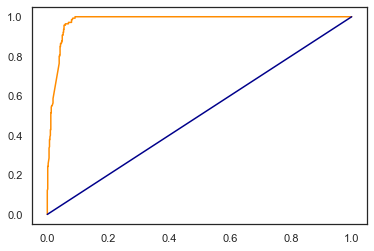

In [24]:
fprs,tprs,thresholds = roc_curve(y_train, cvec_rbf_train_score)
AUROC = auc(fprs,tprs)
plt.plot(fprs,tprs,color='darkorange')
plt.plot([0,1],[0,1],color='darkblue')
print(AUROC)

### Fining Tuning with Threshold Moving

In [25]:
"""
# calculate fscore
fscore = (2*p*r)/(p+r)
#locate the index of the largest fscore
ix=np.argmax(fscore)
print('Best Threshold=%f, F-score=%.3f'%(thresholds[ix],fscore[ix]))

# plot the precision recall curve

plt.plot(r, p, marker='.', label='')
plt.scatter(r[ix],p[ix],marker='X',color='red',label='Best')
plt.xlabel('Recall')
plt.ylabel('Precision')
"""

"\n# calculate fscore\nfscore = (2*p*r)/(p+r)\n#locate the index of the largest fscore\nix=np.argmax(fscore)\nprint('Best Threshold=%f, F-score=%.3f'%(thresholds[ix],fscore[ix]))\n\n# plot the precision recall curve\n\nplt.plot(r, p, marker='.', label='')\nplt.scatter(r[ix],p[ix],marker='X',color='red',label='Best')\nplt.xlabel('Recall')\nplt.ylabel('Precision')\n"

In [26]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):

    fscore = (2*precisions*recalls)/(precisions+recalls)
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.plot(thresholds, fscore[:-1], "k:", label="fscore")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    ix=np.argmax(fscore)
    plt.scatter(thresholds[ix],fscore[ix],marker='X',color='red',label='Best')
    #print('Best Threshold=%f, F-score=%.3f'%(thresholds[ix],fscore[ix]))
    threshold_= thresholds[ix]
    return threshold_


In [27]:
# This function allows for dataframes to be displayed side-by-side

def display_side_by_side(*args):
    html_str = ''
    for df in args:
        html_str += df.to_html()
    display_html(html_str.replace('table', 'table style="display:inline"'), raw = True)

In [28]:
def adjusted_prediction(y_scores,t):
    return [1 if y >= t else 0 for y in y_scores]

#### Linear Kernel

In [29]:
precision_linear, recall_linear, thresholds_linear = precision_recall_curve(y_train, cvec_linear_train_score)

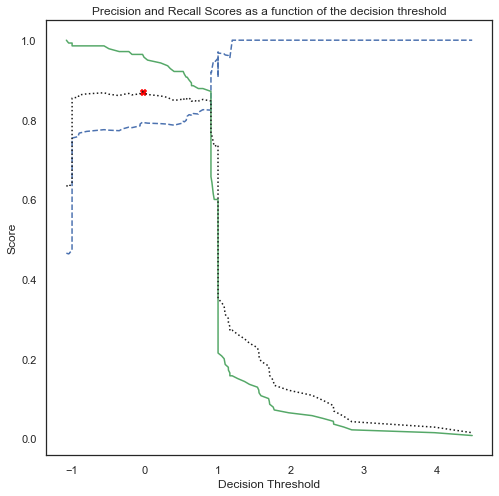

In [30]:
# plot the precion, recall and f score a function of the decision threshold based on the linear kernal

adjusted_threshold_linear=plot_precision_recall_vs_threshold(precision_linear, recall_linear, thresholds_linear)

In [31]:
print(adjusted_threshold_linear)

-0.034280886615179806


In [32]:
cvec_linear_train_new_preds=adjusted_prediction(cvec_linear_train_score,adjusted_threshold_linear)

In [33]:
# Generating a new confusion matrix on the training results

metrics.confusion_matrix_dataframe(y_train, 
                                   cvec_linear_train_new_preds,
                                   columns = ["Predicted Related (Ajusted)", "Predicted Irrelated(Ajusted)"],
                                   index   = ["Actual Related", "Actual Irrelated"])

,Predicted Related (Ajusted),Predicted Irrelated(Ajusted)
Actual Related,656,35
Actual Irrelated,5,135


In [34]:
summary_training_linear_new=metrics.binary_classification_summary(y_train, cvec_linear_train_new_preds,cvec_linear_train_score,'summary_training_linear_adjusted')

#### rbf Kernal

In [35]:
precision_rbf, recall_rbf, thresholds_rbf= precision_recall_curve(y_train, cvec_rbf_train_score)


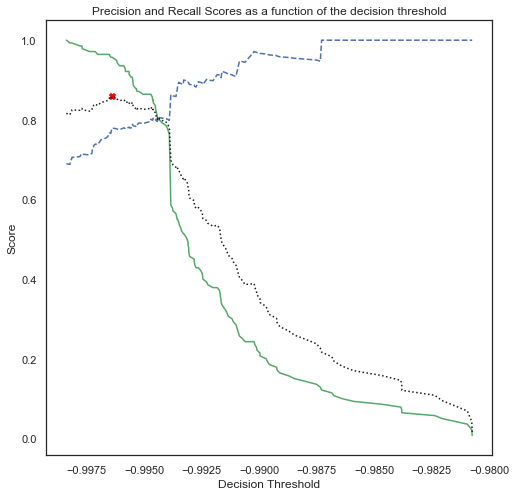

In [36]:
# plot the precion, recall and f score a function of the decision threshold based on the rbf kernal

adjusted_threshold_rbf = plot_precision_recall_vs_threshold(precision_rbf, recall_rbf, thresholds_rbf)

In [37]:
print(adjusted_threshold_rbf)

-0.9963872006363843


In [38]:
cvec_rbf_train_new_preds=adjusted_prediction(cvec_rbf_train_score,adjusted_threshold_rbf)

In [39]:
# Generating a confusion matrix on the test results

metrics.confusion_matrix_dataframe(y_train, 
                                   cvec_rbf_train_new_preds,
                                   columns = ["Predicted Related (Ajusted)", "Predicted Irrelated(Ajusted)"],
                                   index   = ["Actual Related", "Actual Irrelated"])

,Predicted Related (Ajusted),Predicted Irrelated(Ajusted)
Actual Related,653,38
Actual Irrelated,6,134


In [40]:
summary_training_rbf_new=metrics.binary_classification_summary(y_train, cvec_rbf_train_new_preds,cvec_rbf_train_score,'summary_training_rbf_adjusted')


In [41]:
display_side_by_side(summary_training_linear,summary_training_linear_new,summary_training_rbf,summary_training_rbf_new)

,summary_training_linear
Accuracy,0.949458
Sensitivity,0.950000
Specificity,0.949349
AUROC,0.984257
,summary_training_linear_adjusted
Accuracy,0.951865
Sensitivity,0.964286
Specificity,0.949349
AUROC,0.984257
,summary_training_rbf


**TFIDF Vectorizer**

In [42]:
# Setting up the pipeline

tvec_svc_pipe = Pipeline([("tvec", TfidfVectorizer()), 
                          ("bestf",SelectKBest()),
                          ("svc", SVC())])

# Setting TFIDF and pipe hyperparameters

tvec_linear_pipe_params = {"tvec__max_features": [250], 
                    "tvec__ngram_range" : [(1,2)], 
                    "tvec__stop_words"  : [stop_words],
                    "tvec__binary"      : [True],
                    "tvec__min_df"      : [2],
                    "bestf__score_func" : [chi2],
                    "bestf__k"          : [100,200,400], 
                    "svc__C"            : [5,10,20],
                    "svc__kernel"       : ["linear"],
                    "svc__probability"  : [True]}
                    
# Instantiating the grid search

tvec_linear_svc_gs = GridSearchCV(tvec_svc_pipe, 
                           param_grid = tvec_linear_pipe_params, 
                           cv         = 10,
                           scoring    = 'roc_auc'
                            )


# Fitting the model to the training data

tvec_linear_svc_gs.fit(X_train, y_train);

# print best parameter after tuning 
print(tvec_linear_svc_gs.best_params_) 


/Users/Ying/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/Ying/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/Ying/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/Ying/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 292, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/Ying/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/Ying/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 740, in _fit_transform_o

/Users/Ying/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/Ying/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/Ying/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/Ying/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 292, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/Ying/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/Ying/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 740, in _fit_transform_o

/Users/Ying/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/Ying/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/Ying/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/Ying/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 292, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/Ying/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/Ying/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 740, in _fit_transform_o

/Users/Ying/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/Ying/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/Ying/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/Ying/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 292, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/Ying/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/Ying/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 740, in _fit_transform_o

/Users/Ying/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/Ying/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/Ying/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/Ying/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 292, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/Ying/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/Ying/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 740, in _fit_transform_o

{'bestf__k': 100, 'bestf__score_func': <function chi2 at 0x7f88b2563ca0>, 'svc__C': 10, 'svc__kernel': 'linear', 'svc__probability': True, 'tvec__binary': True, 'tvec__max_features': 250, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', '

In [43]:
tresults_linear = pd.DataFrame(tvec_linear_svc_gs.cv_results_)

#results.head()
tresults_linear = tresults_linear.sort_values(by='rank_test_score')

#results_linear.round(3).head(20)
tresults_linear[['param_bestf__k','param_tvec__binary','param_svc__C', 'param_tvec__min_df','param_svc__kernel','mean_test_score','std_test_score','rank_test_score']].round(3).head(5)

,param_bestf__k,param_tvec__binary,param_svc__C,param_tvec__min_df,param_svc__kernel,mean_test_score,std_test_score,rank_test_score
1,100,True,10,2,linear,0.852,0.046,1
2,100,True,20,2,linear,0.848,0.046,2
0,100,True,5,2,linear,0.846,0.043,3
3,200,True,5,2,linear,0.841,0.041,4
4,200,True,10,2,linear,0.834,0.042,5


In [44]:
# Generating training predictions

tvec_linear_train_preds = tvec_linear_svc_gs.predict(X_train)
tvec_linear_train_score = tvec_linear_svc_gs.decision_function(X_train)

# Training metrics

summary_training_tlinear = metrics.binary_classification_summary(y_train, tvec_linear_train_preds,tvec_linear_train_score,'summary_training_linear_tf')

In [45]:
# fprs,tprs,thresholds = roc_curve(y_train, tvec_linear_train_score)
# AUROC = auc(fprs,tprs)
# plt.plot(fprs,tprs,color='darkorange')
# plt.plot([0,1],[0,1],color='darkblue')
# print(AUROC)

In [46]:
precision_tlinear, recall_tlinear, thresholds_tlinear = precision_recall_curve(y_train, tvec_linear_train_score)

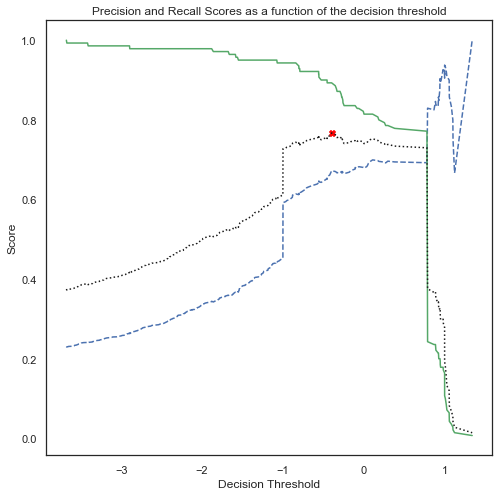

In [47]:
# plot the precion, recall and f score a function of the decision threshold based on the linear kernal

adjusted_threshold_tlinear=plot_precision_recall_vs_threshold(precision_tlinear, recall_tlinear, thresholds_tlinear)

In [48]:
tvec_linear_train_new_preds=adjusted_prediction(tvec_linear_train_score,adjusted_threshold_tlinear)

In [49]:
summary_training_tlinear_new=metrics.binary_classification_summary(y_train, tvec_linear_train_new_preds,tvec_linear_train_score,'summary_training_tlinear_adjusted')

RBF

In [50]:
# Setting TFIDF and pipe hyperparameters

tvec_rbf_pipe_params = {"tvec__max_features": [250], 
                    "tvec__ngram_range" : [(1,2)], 
                    "tvec__stop_words"  : [stop_words],
                    "tvec__binary"      : [True],
                    "tvec__min_df"      : [2],
                    "bestf__score_func" : [chi2],
                    "bestf__k"          : [50,75,100], 
                    "svc__C"            : [0.005,0.01,0.02],
                    "svc__gamma"        : [0.01,0.02,0.04,0.08],
                    "svc__kernel"       : ["rbf"],
                    "svc__probability"  : [True]}
                    
# Instantiating the grid search

tvec_rbf_svc_gs = GridSearchCV(tvec_svc_pipe, 
                           param_grid = tvec_linear_pipe_params, 
                           cv         = 10,
                           scoring    = 'roc_auc')


# Fitting the model to the training data

tvec_rbf_svc_gs.fit(X_train, y_train);

# print best parameter after tuning 
print(tvec_rbf_svc_gs.best_params_) 


/Users/Ying/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/Ying/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/Ying/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/Ying/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 292, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/Ying/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/Ying/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 740, in _fit_transform_o

/Users/Ying/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/Ying/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/Ying/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/Ying/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 292, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/Ying/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/Ying/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 740, in _fit_transform_o

/Users/Ying/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/Ying/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/Ying/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/Ying/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 292, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/Ying/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/Ying/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 740, in _fit_transform_o

/Users/Ying/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/Ying/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/Ying/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/Ying/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 292, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/Ying/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/Ying/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 740, in _fit_transform_o

/Users/Ying/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/Ying/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/Ying/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/Ying/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 292, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/Ying/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/Ying/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 740, in _fit_transform_o

{'bestf__k': 100, 'bestf__score_func': <function chi2 at 0x7f88b2563ca0>, 'svc__C': 10, 'svc__kernel': 'linear', 'svc__probability': True, 'tvec__binary': True, 'tvec__max_features': 250, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', '

In [51]:
tresults_rbf = pd.DataFrame(tvec_rbf_svc_gs.cv_results_)
tresults_rbf = results_rbf.sort_values(by='rank_test_score')
#results_rbf.head()

tresults_rbf[['param_bestf__k','param_cvec__binary','param_svc__C', 'param_svc__kernel','param_svc__gamma','mean_test_score','std_test_score', 'rank_test_score']].round(3).head(5)

,param_bestf__k,param_cvec__binary,param_svc__C,param_svc__kernel,param_svc__gamma,mean_test_score,std_test_score,rank_test_score
17,350,True,0.01,rbf,0.1,0.880,0.043,1
29,350,True,10,rbf,0.1,0.880,0.038,2
21,350,True,0.1,rbf,0.1,0.879,0.044,3
25,350,True,1,rbf,0.1,0.879,0.044,4
13,200,True,10,rbf,0.1,0.877,0.038,5


In [52]:
# Generating training predictions

tvec_rbf_train_preds = tvec_rbf_svc_gs.predict(X_train)
tvec_rbf_train_score = tvec_rbf_svc_gs.decision_function(X_train)

# Training metrics

summary_training_trbf = metrics.binary_classification_summary(y_train, tvec_rbf_train_preds,tvec_rbf_train_score,'summary_training_rbf_tf')

In [53]:
precision_trbf, recall_trbf, thresholds_trbf = precision_recall_curve(y_train, tvec_rbf_train_score)

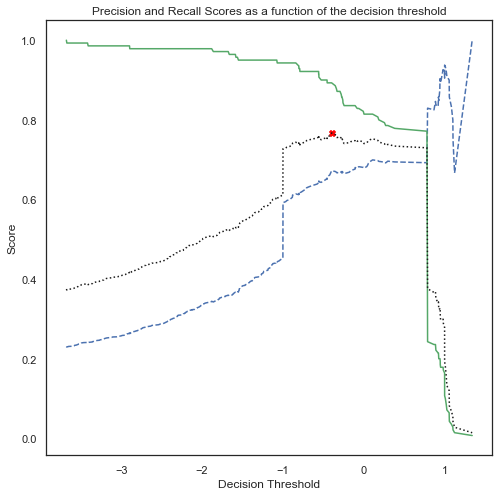

In [54]:
# plot the precion, recall and f score a function of the decision threshold based on the linear kernal

adjusted_threshold_trbf=plot_precision_recall_vs_threshold(precision_trbf, recall_trbf, thresholds_trbf)

In [55]:
tvec_rbf_train_new_preds=adjusted_prediction(tvec_rbf_train_score,adjusted_threshold_trbf)

In [56]:
summary_training_trbf_new=metrics.binary_classification_summary(y_train, tvec_rbf_train_new_preds,tvec_rbf_train_score,'summary_training_trbf_adjusted')

# Compare Models

In [57]:
display_side_by_side(summary_training_linear_new,summary_training_rbf_new,summary_training_tlinear_new,summary_training_trbf_new)

,summary_training_linear_adjusted
Accuracy,0.951865
Sensitivity,0.964286
Specificity,0.949349
AUROC,0.984257
,summary_training_rbf_adjusted
Accuracy,0.947052
Sensitivity,0.957143
Specificity,0.945007
AUROC,0.979135
,summary_training_tlinear_adjusted


### Validating on test dataset

In [58]:
# Generating test predictions based on linear kernel

cvec_linear_svc_preds_test       = cvec_linear_svc_gs.predict(X_test)

cvec_linear_svc_score_test       = cvec_linear_svc_gs.decision_function(X_test)


In [59]:
cvec_linear_svc_preds_test_new=adjusted_prediction(cvec_linear_svc_score_test,adjusted_threshold_linear)

In [60]:
# # Generating a confusion matrix on the test results based on linear kernal

# metrics.confusion_matrix_dataframe(y_test, 
#                                    cvec_linear_svc_preds_test_new,
#                                    columns = ["Predicted Related (Ajusted)", "Predicted Irrelated(Ajusted)"],
#                                    index   = ["Actual Related", "Actual Irrelated"])

In [61]:
summary_linear_test_new = metrics.binary_classification_summary(y_test, cvec_linear_svc_preds_test_new,cvec_linear_svc_score_test,'summary_linear_test_adjusted')

In [62]:
# Generating test predictions based on linear kernel

cvec_rbf_svc_preds_test       = cvec_rbf_svc_gs.predict(X_test)

cvec_rbf_svc_score_test       = cvec_rbf_svc_gs.decision_function(X_test)


In [63]:
cvec_rbf_svc_preds_test_new = adjusted_prediction(cvec_rbf_svc_score_test,adjusted_threshold_rbf)

In [64]:
summary_rbf_test_adjusted = metrics.binary_classification_summary(y_test, cvec_rbf_svc_preds_test_new,cvec_rbf_svc_score_test,'summary_rbf_test_adjusted')

In [65]:
# Generating test predictions based on linear kernel

tvec_linear_svc_preds_test       = tvec_linear_svc_gs.predict(X_test)

tvec_linear_svc_score_test       = tvec_linear_svc_gs.decision_function(X_test)


In [66]:
tvec_linear_svc_preds_test_new=adjusted_prediction(tvec_linear_svc_score_test,adjusted_threshold_tlinear)

In [72]:
summary_tlinear_test_new = metrics.binary_classification_summary(y_test, tvec_linear_svc_preds_test_new,tvec_linear_svc_score_test,'summary_linear_test_adjusted')

In [68]:
# Generating test predictions based on rbf kernel

tvec_rbf_svc_preds_test       = tvec_rbf_svc_gs.predict(X_test)

tvec_rbf_svc_score_test       = tvec_rbf_svc_gs.decision_function(X_test)

In [69]:
tvec_rbf_svc_preds_test_new=adjusted_prediction(tvec_rbf_svc_score_test,adjusted_threshold_trbf)

In [73]:
summary_trbf_test_new = metrics.binary_classification_summary(y_test, tvec_rbf_svc_preds_test_new,tvec_rbf_svc_score_test,'summary_rbf_test_adjusted')

In [74]:
display_side_by_side(summary_linear_test_new,summary_rbf_test_adjusted,summary_tlinear_test_new,summary_trbf_test_new)

,summary_linear_test_adjusted
Accuracy,0.820144
Sensitivity,0.595745
Specificity,0.865801
AUROC,0.848991
,summary_rbf_test_adjusted
Accuracy,0.823741
Sensitivity,0.617021
Specificity,0.865801
AUROC,0.832550
,summary_linear_test_adjusted


In [95]:
summary_linear_test_new

,summary_linear_test_adjusted
Accuracy,0.820144
Sensitivity,0.595745
Specificity,0.865801
AUROC,0.848991


## Save the model to disk


In [ ]:
import pickle

cvec_svc_gs_file = 'cvec_svc_gs.pkl'
pickle.dump(cvec_svc_gs, open(cvec_svc_gs_file, 'wb'))

In [ ]:
tvec_svc_gs_file = 'tvec_svc_gs.pkl'
pickle.dump(tvec_svc_gs, open(tvec_svc_gs_file, 'wb'))

## Use Prediction Model

In [ ]:
# load the models from disk
cvec_svc_gs_load = pickle.load(open(cvec_svc_gs_file, 'rb'))
tvec_svc_gs_load = pickle.load(open(tvec_svc_gs_file, 'rb'))

#load_cvec_svc_gs = pickle.load(cvec_svc_gs)
#load_tvec_svc_gs = pickle.load(tvec_svc_gs)




In [75]:
Model_picked=cvec_linear_svc_gs

In [96]:
def predict(dataframe):

    pred_text= dataframe["lemmatized_text"]
    
    # For cvec models
   
    pred_result = Model_picked.predict(pred_text) 
       
    vec_predictions = pd.DataFrame([np.array(pred_text),pred_result],index = ["body","label"]).T
    
    # Saving the dataframes as csvs
    vec_predictions.to_csv("./Reddit Data/eczema-all-2021-01-29_pred.csv")

In [97]:
test_data= pd.read_csv('./Reddit Data/eczema-all-2021-01-29.csv', encoding="iso-8859-1" )


test_data.head()

,Unnamed: 0,Author,body
0,0,Taro-Sharp,i often find myself just scrolling through thi...
1,1,lBiNgUsl,Is anyone having mask eczema \nI've been weari...
2,3,SokkerGood,Currently in the midst of recovering from a ba...
3,6,awkwardly-british,Does this mean I have an infection?\n\nI've (F...
4,7,lj2900,Does hyperpigmentation go away?


In [98]:
test_data=test_data[test_data['body'].notnull()]

In [99]:
test_data = cleaning_data(test_data)


In [100]:
predict(test_data)
